In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Energy yield example
This notebook shows an example for energy yield simulations of GaInP/GaAs tandem devices for a location at Golden, CO, USA.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pvcircuit as pvc
import zipfile
import pytz
from pathlib import Path
import re
from pvcircuit.qe import EQE, EQET, TemperatureModel, ModelType
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
import matplotlib.dates as mdates

from collections import defaultdict



#### Helper

In [69]:
# Load NSRDB file
def load_nsrdb(filepath):

    with zipfile.ZipFile(filepath) as zip_file:
        files = zip_file.namelist()
        with zip_file.open(files[0]) as csv_file:
            meta = pd.read_csv(csv_file, nrows=1, header=0)
        with zip_file.open(files[0]) as csv_file:
            data = pd.read_csv(csv_file, header=2)

        data["timestamp"] = pd.to_datetime(data[["Year", "Month", "Day", "Hour", "Minute"]], utc=True)
        offset_timezone = pytz.FixedOffset(int(meta["Local Time Zone"][0] * 60))
        data["timestamp"] = data["timestamp"].dt.tz_convert(offset_timezone)

        data.set_index("timestamp", inplace=True)

        meteo = data.iloc[:, :32]
        spectra = data.iloc[:, 32:] / 1e3  # convert from W/m^2/um to W/m^2/nm
        wavelength = spectra.columns.str.extract(r"(\d+\.\d+)", expand=True).astype(float).values.flatten() * 1e3

        spectra.fillna(0, inplace=True)
        spectra[spectra < 0] = 0

        return wavelength, spectra, meteo


Load EQE data

In [70]:
# EQE data from https://doi.org/10.1109/JPHOTOV.2017.2783853
tandem_eqe_file = pvc.notebook_datapath.joinpath(r"MP905n5.csv")
bc_eqe_file = pvc.notebook_datapath.joinpath(r"MP846n8.csv")
tandem_eqe_data = pd.read_csv(tandem_eqe_file, index_col=0)
bc_eqe_data = pd.read_csv(bc_eqe_file, index_col=0)

In [71]:
# extract temperatures from column headers
tandem_temperatures = tandem_eqe_data.columns.to_series().str.findall(r"(\d+)C").explode().dropna().astype(int)
bc_temperatures = bc_eqe_data.columns.to_series().str.findall(r"(\d+)C").explode().dropna().astype(int)

In [72]:
# The tandem_eqe file contains measurements of top and bottom cell. We split these here in top and bottom cell EQE..
junctions = np.array([int(name.split("_")[2][0]) if len(name.split("_"))>3 else 1 for name in tandem_eqe_data.columns])

tc_eqe = EQET(wavelength=tandem_eqe_data.index, eqe=tandem_eqe_data.loc[:, junctions == 1], temperature=tandem_temperatures[junctions == 1])
bc_eqe_tandem = EQET(wavelength=tandem_eqe_data.index, eqe=tandem_eqe_data.loc[:, junctions == 2], temperature=tandem_temperatures[junctions == 2])
bc_eqe = EQET(bc_eqe_data.index, bc_eqe_data, bc_temperatures)

(<Axes: xlabel='Wavelength (nm)', ylabel='EQE'>, <Axes: >)

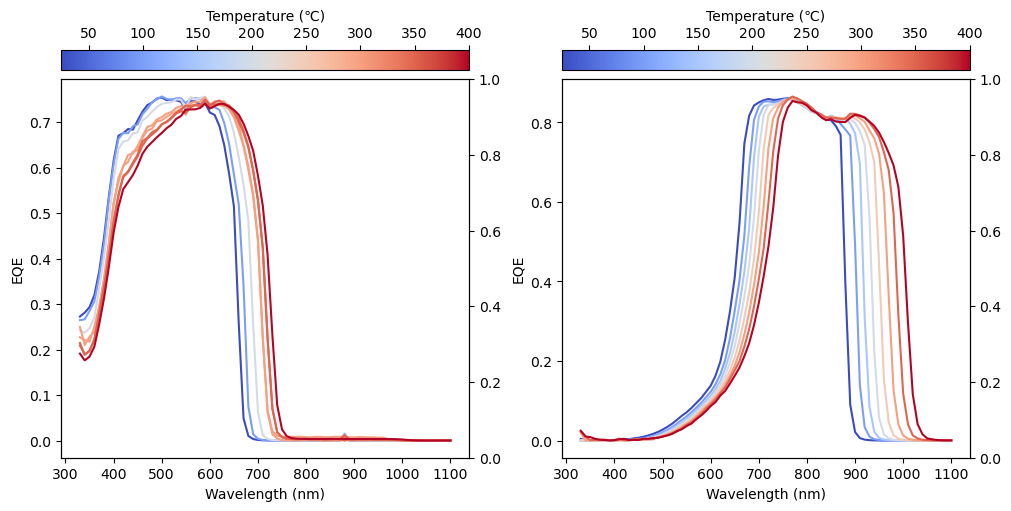

In [73]:
# Plot the top cell and the 2 bottom cell EQEs
fig, axs = plt.subplots(1, 2,figsize=(10,5))

tc_eqe.plot(fig, axs[0])
# bc_eqe_tandem.plot(fig, axs[1])
bc_eqe.plot(fig, axs[1])

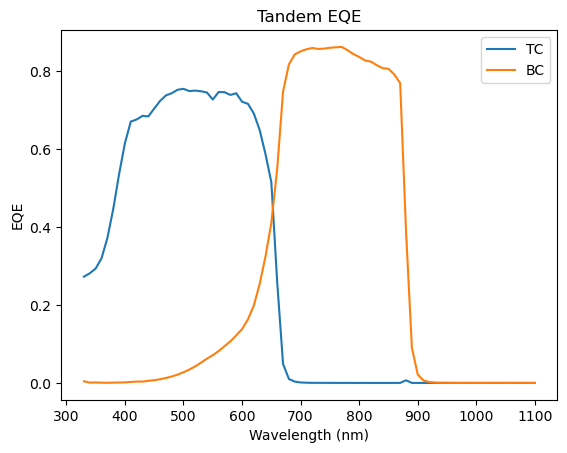

In [74]:
fig,ax = plt.subplots()
ax.plot(tc_eqe.wavelength, tc_eqe.get_eqe_at_temperature(25).eqe)
ax.plot(bc_eqe.wavelength,bc_eqe.get_eqe_at_temperature(25).eqe)
ax.set_ylabel("EQE")  # Add a y-label to the axes.
ax.set_xlabel("Wavelength (nm)")  # Add an x-label to the axes.
ax.set_title("Tandem EQE")
ax.legend(["TC","BC"])


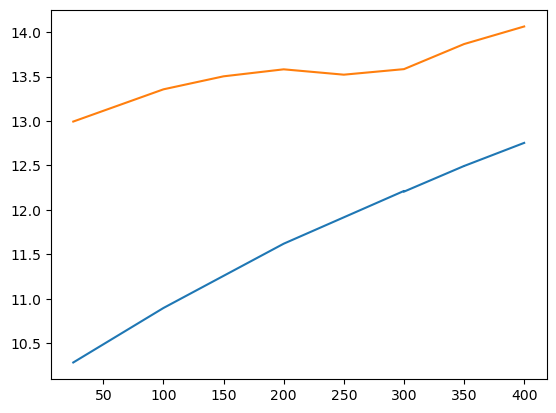

In [75]:
tc_jscs = []
bc_jscs = []
for i in range(tc_eqe.eqe.shape[1]):
    qe = EQE(tc_eqe.wavelength, tc_eqe.eqe[:, i])
    jsc = pvc.qe.JintMD(qe.eqe.flatten(), qe.wavelength.flatten(), Pspec="direct")
    tc_jscs.append(jsc[0])

for i in range(bc_eqe.eqe.shape[1]):
    qe = EQE(bc_eqe.wavelength, bc_eqe.eqe[:, i])
    jsc = pvc.qe.JintMD(EQE=qe.eqe.flatten(), xEQE=qe.wavelength.flatten(), Pspec="direct")
    bc_jscs.append(jsc[0])

fig, ax = plt.subplots()
ax.plot(tc_eqe.temperature, tc_jscs)
ax.plot(bc_eqe.temperature, bc_jscs)

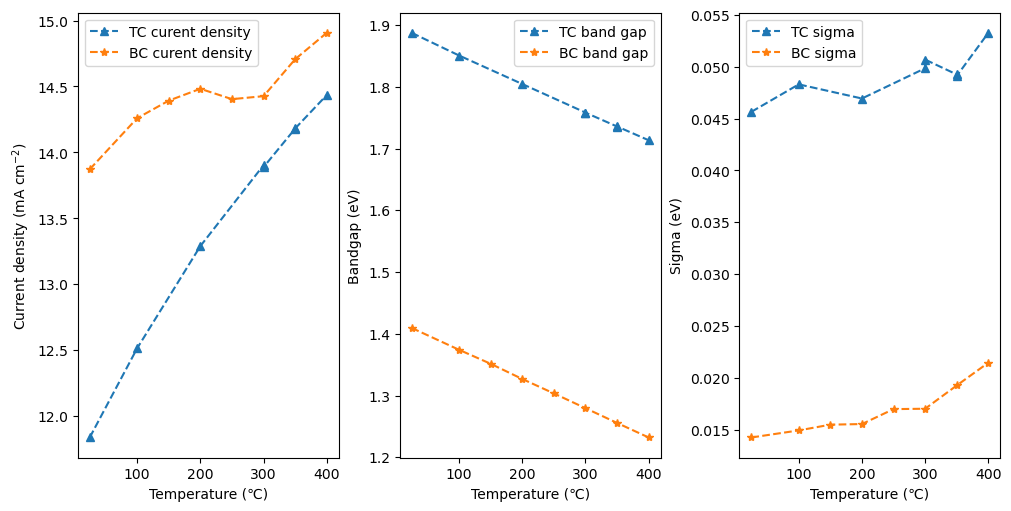

In [76]:
# Integrate EQE(T) first, then interpolate/extrapolate J(T)

tc_eqe.add_spectra(pvc.qe.wvl, pvc.qe.AM15G)
bc_eqe.add_spectra(pvc.qe.wvl, pvc.qe.AM15G)

tc_current = tc_eqe.Jint()
bc_current = bc_eqe.Jint()

fig, ax = plt.subplots(1, 3, layout="constrained", figsize = (10,5))

ax[0].plot(tc_eqe.temperature, tc_current, "^--", label="TC curent density")
ax[0].plot(bc_eqe.temperature, bc_current, "*--", label="BC curent density")

ax[0].set_xlabel("Temperature (℃)")
ax[0].set_ylabel("Current density (mA cm$^{-2}$)")
ax[0].legend()

tc_bandgap, tc_sigma = tc_eqe.calc_Eg_Rau()
bc_bandgap, bc_sigma = bc_eqe.calc_Eg_Rau()

ax[1].plot(tc_eqe.temperature, tc_bandgap, "^--", label="TC band gap")
ax[1].plot(bc_eqe.temperature, bc_bandgap, "*--", label="BC band gap")

ax[1].set_xlabel("Temperature (℃)")
ax[1].set_ylabel("Bandgap (eV)")
ax[1].legend()

ax[2].plot(tc_eqe.temperature, tc_sigma, "^--", label="TC sigma")
ax[2].plot(bc_eqe.temperature, bc_sigma, "*--", label="BC sigma")

ax[2].set_xlabel("Temperature (℃)")
ax[2].set_ylabel("Sigma (eV)")
ax[2].legend()

Load the environmental data

In [77]:
# path to environmental data
environmental_fp = pvc.notebook_datapath.joinpath(r"2021_-105p86_39p81_fixed_tilt_30_180.nsrdb")

# Load spectra and meteorological data
wavelength, spectra, meteo = load_nsrdb(environmental_fp)

# create EY class from meteorological data
ey = pvc.EY.Meteo(wavelength, spectra, meteo["Temperature"], meteo["Wind Speed"], meteo.index)

# Add spectra to class for current calcuations
tc_eqe.add_spectra(wavelength, spectra.T)
bc_eqe.add_spectra(wavelength, spectra.T)

tc_current = tc_eqe.Jint()
bc_current = bc_eqe.Jint()

Plot different spectra based on average photon energy (APE) and corresponding current density in top (TC) and bottom cell (BC)

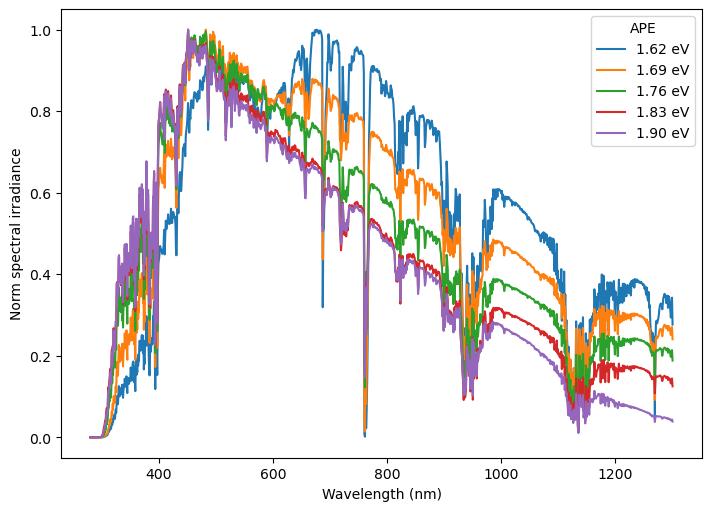

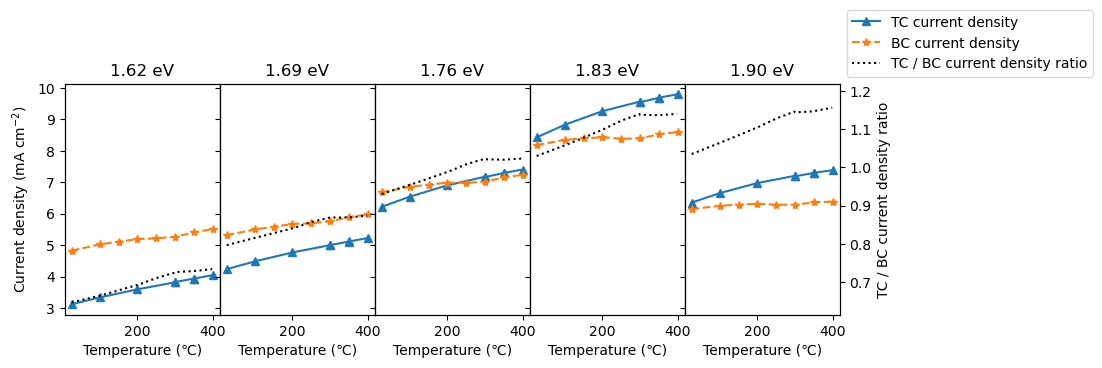

In [78]:
# Filter the wavelength and spectra data
wvl_filter = (ey.wavelength >= 280) & (ey.wavelength <= 1300)
ey.wavelength = ey.wavelength[wvl_filter]
ey.spectra = ey.spectra.iloc[:, wvl_filter]
ey.calc_ape()

# Define the number of bins
nr_bins = 5

# Get APE and irradiance from EY class
average_photon_energy = np.array(ey.average_photon_energy)
irradiance = np.array(ey.irradiance)

# Filter for irradiance > 300
filtered_indices = np.where(irradiance > 300)[0]
filtered_ape = average_photon_energy[filtered_indices]
filtered_irradiance = irradiance[filtered_indices]

# Bin the filtered average_photon_energy data and get bin midpoints
binned = pd.cut(filtered_ape, bins=nr_bins)
bin_midpoints = binned.categories.mid

# Create a DataFrame with the filtered data and binned labels for grouping and index extraction
df = pd.DataFrame({"ape": filtered_ape, "bins": binned, "irradiance": filtered_irradiance})

# Get index of spectra that are closest to the bin midpoints
closest_indices = [
    {
        "bin mid": midpoint,
        "idx closest to mid": filtered_indices[(df[df["bins"] == interval]["ape"] - midpoint).abs().idxmin()],
        "closest value": df.loc[(df[df["bins"] == interval]["ape"] - midpoint).abs().idxmin(), "ape"],
        "irradiance": df.loc[(df[df["bins"] == interval]["ape"] - midpoint).abs().idxmin(), "irradiance"]
    }
    for midpoint, interval in zip(bin_midpoints, binned.categories)
    if not df[df["bins"] == interval].empty
]

closest_indices_df = pd.DataFrame(closest_indices)

# Plot normalized APE binned spectra
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)

# y-axis limits for twin axes
twin_min = float("inf")
twin_max = float("-inf")
for idx in closest_indices_df["idx closest to mid"].values:
    ratio = tc_current[:, idx] / bc_current[:, idx]
    twin_min = min(twin_min, ratio.min())
    twin_max = max(twin_max, ratio.max())

ax.plot(
    ey.wavelength,
    ey.spectra.T.iloc[:, closest_indices_df["idx closest to mid"].values] / ey.spectra.T.iloc[:, closest_indices_df["idx closest to mid"].values].max(),
    "-"
)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Norm spectral irradiance")
ax.legend([f"{ape:.2f} eV" for ape in ey.average_photon_energy[closest_indices_df["idx closest to mid"].values]], title="APE")

# Plot the top cell (TC) and bottom cell (BC) current density for each binned APE as function of temperature
fig, axes = plt.subplots(1, nr_bins, figsize=(10, 3), sharey=True, gridspec_kw={"wspace": 0})
for i, idx in enumerate(closest_indices_df["idx closest to mid"].values):
    ax = axes[i]
    ax.plot(tc_eqe.temperature, tc_current[:, idx], "^-", label="TC current density")
    ax.plot(bc_eqe.temperature, bc_current[:, idx], "*--", label="BC current density")
    ax.set_xlabel("Temperature (℃)")
    ape_val = closest_indices_df.loc[i, "closest value"]
    ax.set_title(f"{ape_val:.2f} eV")

    # Plot the current ratios on second y-axis
    common_temperatures = np.arange(max(tc_eqe.temperature.min(), bc_eqe.temperature.min()), min(tc_eqe.temperature.max(), bc_eqe.temperature.max()))

    tc_current_interp_func = interp1d(tc_eqe.temperature, tc_current[:, idx])
    bc_current_interp_func = interp1d(bc_eqe.temperature, bc_current[:, idx])

    tc_current_interp = tc_current_interp_func(common_temperatures)
    bc_current_interp = bc_current_interp_func(common_temperatures)
    ax2 = ax.twinx()
    ratio_line, = ax2.plot(common_temperatures, tc_current_interp / bc_current_interp, "k:", label="TC / BC ratio")

    ax2.set_ylim(twin_min * 0.95, twin_max * 1.05)
    if i < nr_bins - 1:
        ax2.set_yticklabels([])
        ax2.tick_params(axis="y", which="both", length=0)

axes[0].set_ylabel("Current density (mA cm$^{-2}$)")
ax2.set_ylabel("TC / BC current density ratio")
handles, labels = ax.get_legend_handles_labels()
handles.append(ratio_line)
labels.append("TC / BC current density ratio")
ax.legend(handles, labels, loc=3, bbox_to_anchor=(1, 1))


In [79]:
tc_currents = tc_eqe.get_current_for_temperature(ey.cell_temp, degrees=[2, 3, 4, 5])
bc_currents = bc_eqe.get_current_for_temperature(ey.cell_temp, degrees=[2, 3, 4, 5])

ey.add_currents(tc_currents)
ey.add_currents(bc_currents)

Do the same for the bandgaps. We find top and bottom cell bandgap and sigma (see doi: 10.1002/solr.202300782) and interpolate/extrapolate for the hourly outdoor device temperatures

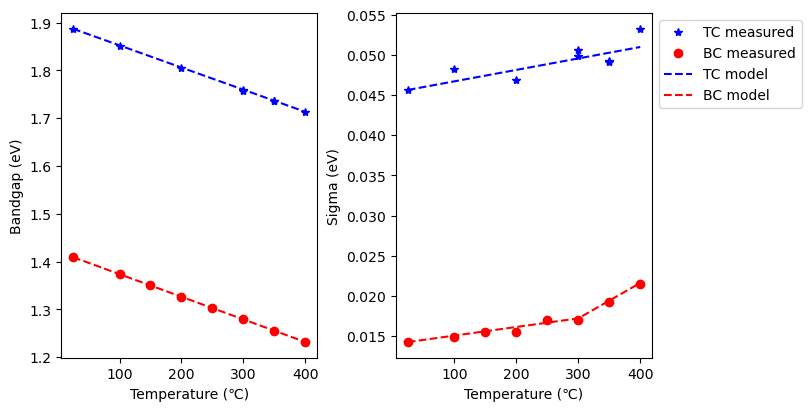

In [80]:
# get bandgap and sigma from measured top cell EQE
tc_bandgap, tc_sigma = tc_eqe.calc_Eg_Rau()

# Fit bandgap with linear model
# bandgap_model = TemperatureModel.fit(psc_eqe.temperature, bandgap, plot="all")
# tc_bandgap_model = TemperatureModel.fit(tc_eqe.temperature, bandgap, plot=None, model_types=[pvc.qe.ModelType.LINEAR])
tc_bandgap_model = TemperatureModel.fit(tc_eqe.temperature, tc_bandgap, model_types=[pvc.qe.ModelType.LINEAR])

pwl = pvc.qe.ModelType.PIECEWISE_LINEAR
pwl.initial_guess[0] = np.mean(tc_eqe.temperature)
tc_sigma_model = TemperatureModel.fit(tc_eqe.temperature, tc_sigma, model_types=pvc.qe.ModelType.LINEAR)

# get bandgap and sigma from measured bottom cell EQE
bc_bandgap, bc_sigma = bc_eqe.calc_Eg_Rau()

# Fit bandgap with linear model
# bandgap_model = TemperatureModel.fit(psc_eqe.temperature, bandgap, plot="all")
bc_bandgap_model = TemperatureModel.fit(bc_eqe.temperature, bc_bandgap, model_types=[pvc.qe.ModelType.LINEAR])

# Fit sigma with piecewise-linear (PWL) model
pwl = pvc.qe.ModelType.PIECEWISE_LINEAR
# PWL needs some help for the split point
pwl.initial_guess[0] = np.mean(tc_eqe.temperature)
bc_sigma_model = TemperatureModel.fit(bc_eqe.temperature, bc_sigma, model_types=pwl)

# plot data
fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
# plot data
ax[0].plot(tc_eqe.temperature, tc_bandgap, "b*", label="TC measured")
ax[0].plot(bc_eqe.temperature, bc_bandgap, "ro", label="BC measured")
ax[1].plot(tc_eqe.temperature, tc_sigma, "b*", label="TC measured")
ax[1].plot(bc_eqe.temperature, bc_sigma, "ro", label="BC measured")

# get the refrence value
tc_eqe_25 = tc_eqe.get_eqe_at_temperature(25)
bc_eqe_25 = bc_eqe.get_eqe_at_temperature(25)
tc_bandgap25, tc_sigma25 = tc_eqe_25.calc_Eg_Rau()
bc_bandgap25, bc_sigma25 = bc_eqe_25.calc_Eg_Rau()

# plot fits
t_range = np.linspace(min(tc_eqe.temperature.min(), bc_eqe.temperature.min()), max(tc_eqe.temperature.max(), bc_eqe.temperature.max()), 50)
ax[0].plot(t_range, tc_bandgap_model.apply(t_range, tc_bandgap25), "b--", label="TC model")
ax[0].plot(t_range, bc_bandgap_model.apply(t_range, bc_bandgap25), "r--", label="BC model")
ax[1].plot(t_range, tc_sigma_model.apply(t_range, tc_sigma25), "b--", label="TC model")
ax[1].plot(t_range, bc_sigma_model.apply(t_range, bc_sigma25), "r--", label="BC model")

ax[0].set_xlabel("Temperature (℃)")
ax[0].set_ylabel("Bandgap (eV)")
ax[1].set_xlabel("Temperature (℃)")
ax[1].set_ylabel("Sigma (eV)")
ax[1].legend(loc=2, bbox_to_anchor=(1, 1))

In [81]:
# add bandgap and sigma to the EY class using the cell temperature derived in the EY class
ey.add_bandgaps(tc_bandgap_model.apply(ey.cell_temp, tc_bandgap25))
ey.add_bandgaps(bc_bandgap_model.apply(ey.cell_temp, bc_bandgap25))
ey.add_sigmas(tc_sigma_model.apply(ey.cell_temp, tc_sigma25))
ey.add_sigmas(bc_sigma_model.apply(ey.cell_temp, bc_sigma25))

Load a device model

In [82]:
# We use a 3T model since this can handel 2T current-matched, 4T MPP and 3T devices.
dev3T = pvc.Tandem3T()
dev3T.set(name="iii-v tandem", Rz=0)
dev3T.top.set(Eg=0, J0ratio=[350], Jext=0 * 1e-3, Gsh=3.6e-4, Rser=1.12, n=[1.78], beta=0)
dev3T.bot.set(Eg=0, J0ratio=[1600], Jext=0 * 1e-3, Gsh=1.3e-4, Rser=0.84, n=[1.38], beta=0)
print(dev3T)

iii-v tandem: <pvcircuit.tandem3T.Tandem3T class>
T = 25.0 C, Rz= 0 Ω cm2, Rt= 1.12 Ω cm2, Rr = 0.84 Ω cm2

top: <pvcircuit.junction.Junction class>
Eg = 0.00 eV, TC = 25.0 C
Jext = 0.0 mA/cm2, JLC = 0.0 mA/cm2
Gsh = 0.00036 S/cm2, Rser = 1.12 Ωcm2
lightA = 1 cm2, totalA = 1 cm2
pn = -1, beta = 0, gamma = 0
   n    J0ratio   J0(A/cm2) 
  db       1      5.371e-01 
 1.78    350.00   1.196e+01 

bot: <pvcircuit.junction.Junction class>
Eg = 0.00 eV, TC = 25.0 C
Jext = 0.0 mA/cm2, JLC = 0.0 mA/cm2
Gsh = 0.00013 S/cm2, Rser = 0.84 Ωcm2
lightA = 1 cm2, totalA = 1 cm2
pn = 1, beta = 0, gamma = 0
   n    J0ratio   J0(A/cm2) 
  db       1      5.371e-01 
 1.38   1600.00   1.522e+02 


In [83]:
# eyf = ey.filter_custom(~ey.SpecPower.isna())
operation_modes = ["CM", "MPP", "VM-21-r", "VM-21-s"]
ey_results = {}
for oper in operation_modes:
    res = ey.run_ey(dev3T, oper, multiprocessing=True)
    ey_results[oper] = res

Running iii-v tandem in mode CM with 104 processes: 100%|██████████| 8760/8760 [00:02<00:00, 4093.26it/s]
Running iii-v tandem in mode MPP with 104 processes: 100%|██████████| 8760/8760 [00:04<00:00, 2144.01it/s]
Running iii-v tandem in mode VM-21-r with 104 processes: 100%|██████████| 8760/8760 [00:04<00:00, 1880.65it/s]
Running iii-v tandem in mode VM-21-s with 104 processes: 100%|██████████| 8760/8760 [00:04<00:00, 1824.02it/s]


Text(0, 0.5, 'Energy harvesting efficiency (%)')

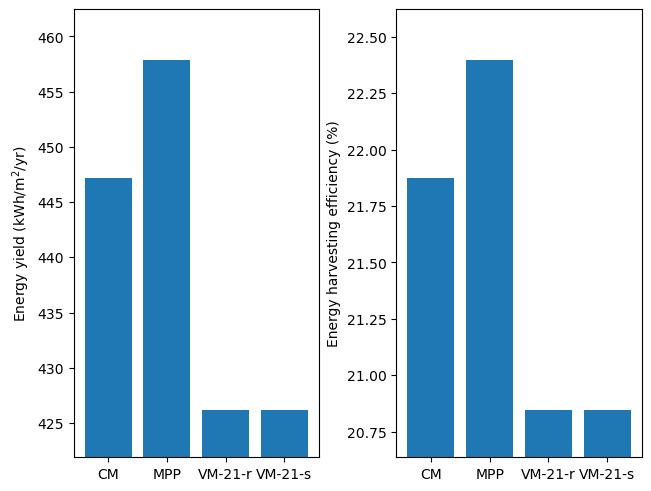

In [84]:
values = np.array(list(ey_results.values())).T  # Transpose to separate tuple elements
fig, axs = plt.subplots(1, 2, constrained_layout=True)
axs[0].bar(operation_modes, values[0, :])
axs[0].set_ylim(0.99 * min(values[0, :]), 1.01 * max(values[0, :]))
axs[0].set_ylabel(r"Energy yield (kWh/m$^2$/yr)")

ehe = values[1, :] * 100
axs[1].bar(operation_modes, values[1, :] * 100)
axs[1].set_ylim(0.99 * min(ehe), 1.01 * max(ehe))
axs[1].set_ylabel(r"Energy harvesting efficiency (%)")